In [ ]:
# To push the split for training and developing data faster
# we need to skip the index when the timeline is not continuous. (This is covered by dropping all na values)
# The problem arise when there is not enough data after skipping.
# When that happen, the program skip again, leaving some valuable data behind.
# The best thing that can happen is when we skip the second time, if the timeline is not continuous, it will skip
# to the earliest not continous timeline. If we doesn't have any marker, we must find it manually by looping each index.
# So we need to have a marker. It will be put in the raw data files.

# Put timeskip marker in the raw datafiles. (New columns name Timeskip, value is the first time data appear again after the index)
# If after the skip, the timeline is not continous, find the time skip marker and put the position there.
# The refined file doesn't have data in PM (Missing data -> np.nan), findout why *** Not Done 2018 have some problem
# The split for training and developing data has index out of bound, fix it.
# The split for target have some difficulty:
# we can't shift the data so we have to merge it with splitting training data
# When splitting the data 


# We don't need to remove the data, we can just calculate like normal.
# Then in the finished file, we drop all data which deemed Missing. 
# When putting data to the model, we need to figure out a way to know which data is dropped

In [ ]:
!pip install --upgrade sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px
from itertools import product
import warnings
import statsmodels.api as sm
plt.style.use('seaborn-darkgrid')

Requirement already up-to-date: sklearn in /usr/local/lib/python3.7/dist-packages (0.0)


In [ ]:
from IPython.core.debugger import set_trace

#Cong thuc tinh duoc lay tu duong link nay: 
#http://cem.gov.vn/storage/news_file_attach/QD%201459%20TCMT%20ngay%2012.11.2019%20AQI.pdf
#Cong thuc nay se lay input la 1 dataframe so do hop chat cho output ra 1 series gom so AQI cua moi gio (Lon nhat trong tat ca hop chat)
def calculate_AQI_h(data = None, formular = 1):

    def create_BP_df():
        BP_Ii = [0,50,100,150,200,300,400,500]
        BP_O3_1h = [0,160,200,300,400,800,1000,1200]
        BP_O3_8h = [0,120,170,210,400]
        BP_CO = [0,10000,30000,45000,60000,90000,120000,150000]
        BP_SO2 = [0,125,350,550,800,1600,2100,2630]
        BP_NO2 = [0,100,200,700,1200,2350,3100,3850]
        BP_PM10 = [0,50,150,250,350,420,500,600]
        BP_PM25 = [0,25,50,80,150,250,350,500]
        BP = pd.DataFrame(data = [range(1,9),BP_Ii, BP_O3_1h, BP_O3_8h, BP_CO, BP_SO2, BP_NO2, BP_PM10, BP_PM25],
                          index=['I','Ii','O3','O3_8h','CO','SO2','NO2','PM10','PM25'], dtype= np.int64)
        BP = BP.transpose().set_index('I')
        #Add a upper to calculate I = 8
        BP.loc[9] = [999999,999999,999999,999999,999999,999999,999999,999999]
        BP.index = BP.index.astype(np.int64)
        return BP
    
    def calculate_BP_I(polutant_data, BP = create_BP_df()):
        """
        For: Calculating I for all polutant values. I then used to calculate AQI
        Input:
            + polutant_data: dataframe values of all polutant
            + BP: BP table
        Ouput:
            + DataFrame with I of all pollutants [CO, NO2, O3, PM25, SO2]
        """
        result_I = []
        BP_polutant_column = BP.loc[:,polutant_data.name]
        result_I = polutant_data.apply(lambda x: BP_polutant_column.ge(x).idxmax() - 1)
        return result_I
    
    #Cong thuc 1 = ((Ii[i+1] - Ii[i])/ (BP[i+1] - BP[i]))* (C[h] - BP[i]) +Ii[i]
    def calculate_AQI_formular(polutant_data, I, nowcast, BP = create_BP_df()):
        result = []
#         print(polutant_data)
        for data in zip(polutant_data.index, polutant_data.values, I.values):
            polutant_name, polutant_value, I = data
            I = int(I)
            if polutant_name == 'PM25':
                try:
                    if nowcast == 0:
                        AQI = 0
                    else:
                        AQI = ((BP.loc[I + 1,'Ii'] - BP.loc[I, 'Ii']) / 
                               (BP.loc[I + 1, polutant_name] - BP.loc[I, polutant_name]) * 
                               (nowcast - BP.loc[I, polutant_name])) + BP.loc[I, 'Ii']
                        AQI = AQI.round(0)
                except KeyError:
                    if I == 0:
                        AQI = 0
                    else:
                        AQI = 500
            else:
                try:
                    AQI = ((BP.loc[I + 1,'Ii'] - BP.loc[I, 'Ii']) / 
                           (BP.loc[I + 1, polutant_name] - BP.loc[I, polutant_name]) * 
                           (polutant_value - BP.loc[I, polutant_name])) + BP.loc[I, 'Ii']
                    AQI = AQI.round(0)
                except KeyError:
                    if I == 0:
                        AQI = 0
                    else:
                        AQI = 500                
            result.append(AQI)
        return result
        
    #Cong thuc tinh nowcast danh rieng cho PM25
    def nowcast(polutant_data, calculating_hour_value):
        time = calculating_hour_value.name
        # Loc 12h gan nhat
        tmp_12h_data_storage = polutant_data.loc[
            idx[time - pd.Timedelta(hours=12) : time]]
        # Dao nguoc index lai
        tmp_12h_data_storage = tmp_12h_data_storage.iloc[::-1]
        #Kiem tra xem trong 3 gio gan nhat thi it nhat 2 gio phai co so lieu
        #Neu khong qua duoc check o tren thi so lieu tinh duoc dat la 0
        if tmp_12h_data_storage.iloc[0:3].eq(0).sum().values[0] > 1:
            calculating_hour_value.loc[:] = 0
        elif len(tmp_12h_data_storage) < 2:
            calculating_hour_value.loc[:] = 0
        else:
            non_zero_array = tmp_12h_data_storage[tmp_12h_data_storage != 0]
            min_value = non_zero_array.min().values[0]                
            max_value = non_zero_array.max().values[0]
            try:
                w = min_value / max_value
            except ZeroDivisionError:
                print(time)
            if w < 1/2:
                w = 1/2
            #Tinh gia tri nowcast dua theo cong thuc
            if w == 1/2:
                nowcast = sum(w**i * tmp_12h_data_storage.iloc[i-1] for i in range(1, len(tmp_12h_data_storage)+1))
            else:
                nowcast = sum([(w**(i-1)) * tmp_12h_data_storage.iloc[i-1] for i in range(1,len(tmp_12h_data_storage)+1)]) / sum([(w**(i-1)) for i in range(1,len(tmp_12h_data_storage) + 1)])
            calculating_hour_value = nowcast.values[0]
        return calculating_hour_value
    
    #Gia tri so sanh de tinh muc do AQI
    def categorize_AQI(AQI_data):
        """
        Input: Series of AQI_values
        Output: Series of AQI category
        7 categories [Good, Moderate, Unhealthy for Sensitive, Unhealthy, Very Unhealthy, Hazardous, Out of AQI]
        range of categories [0-50, 51-100, 101-150, 151-200, 201-300, 301-500, >500]
        """
        bins = [-1, 50, 100, 150, 200, 300, 500, np.inf]
        labels = ["Good", "Moderate", "Unhealthy for Sensitive", "Unhealthy", "Very Unhealthy", "Hazardous", "Beyond AQI"]
        return pd.cut(AQI_data, bins=bins, labels=labels)
    
# ==========================================================================================================

    idx = pd.IndexSlice
    _global_BP = create_BP_df()
    sorted_data = data.sort_index().copy()
#     set_trace()
    tmp = sorted_data[['PM25']].apply(
            (lambda x: nowcast(sorted_data[['PM25']], x,))
            , axis=1,
            result_type='broadcast'
        )
#         set_trace()
    sorted_data['NowCast'] = tmp.values

    #Air index number of all polutant data
    I_number = sorted_data.drop('NowCast', axis=1).apply((lambda x: calculate_BP_I(x, _global_BP)), axis=0, result_type='broadcast')
    calculated_AQI = I_number.apply((lambda I: calculate_AQI_formular(sorted_data.loc[I.name, :], I, sorted_data.loc[I.name, 'NowCast'], _global_BP)),
                                axis=1, result_type='broadcast')
    calculated_AQI['AQI_h'] = calculated_AQI.max(axis=1)
    calculated_AQI['AQI_h_Polutant'] = calculated_AQI.idxmax(axis=1)
    calculated_AQI['AQI_h_label'] = categorize_AQI(calculated_AQI['AQI_h'])
    calculated_AQI['NowCast'] = sorted_data['NowCast']
    calculated_AQI['AQI_h_I'] = calculated_AQI['AQI_h_label'].cat.codes + 1
    return calculated_AQI

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/MyDrive/KLTN'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# TP HCM
import pandas as pd
import numpy as np
import glob
import xarray as xr

idx = pd.IndexSlice

_HCM_daisuquanmy_data_path = root_path + r'/Data/dai_su_quan_my'
_HCM_daisuquanmy_data_files = glob.glob(_HCM_daisuquanmy_data_path + '/raw_data/HoChiMinhCity_*YTD*.csv')
print(_HCM_daisuquanmy_data_files)
USEm_HCM_df = pd.DataFrame()
for file in _HCM_daisuquanmy_data_files:
    print('Currently processing file \n{}'.format(file))
    USEm_HCM_df = USEm_HCM_df.append(pd.read_csv(file, parse_dates=True))

# Remove site year 2015 because inconsistency data
# daisuquanmy_df = daisuquanmy_df[(daisuquanmy_df['Year'] != 2015)]
USEm_HCM_df.drop(columns=['Site', 'Parameter', 'AQI', 'AQI Category','NowCast Conc.', 'Conc. Unit', 'Duration'], inplace=True)
USEm_HCM_df['Date (LT)'] = pd.to_datetime(USEm_HCM_df['Date (LT)'])
# Remove duplicate, fill in missing index and set ['Date (LT)'] as index and sort
USEm_HCM_df.drop_duplicates(subset ="Date (LT)", 
                     keep = "first", inplace = True)
USEm_HCM_df = USEm_HCM_df.sort_values(by=['Date (LT)'])
USEm_HCM_df = USEm_HCM_df.set_index('Date (LT)').asfreq('H')
USEm_HCM_df.sort_index(inplace=True)
# For all Raw Conc <= 0 QC Name must be Missing. Raw Conc change to -999
USEm_HCM_df.loc[USEm_HCM_df['Raw Conc.'] <= 0, 'Raw Conc.'] = -999
USEm_HCM_df.loc[USEm_HCM_df['Raw Conc.'] >= 900, 'Raw Conc.'] = -999
USEm_HCM_df.loc[USEm_HCM_df['Raw Conc.'] <= 0, 'QC Name'] = 'Missing'

USEm_HCM_df = USEm_HCM_df.replace(-999, np.nan)
# Change Raw Conc to PM25
USEm_HCM_df.rename(columns={'Raw Conc.': 'PM25'}, inplace=True)
# Fill missing data
USEm_HCM_df.fillna(method='ffill', limit=2, inplace=True)
USEm_HCM_df.fillna(method='bfill', limit=2, inplace=True)

# For year 2015 only, take data after 2015-12-09 14:00:00
USEm_HCM_df = USEm_HCM_df.loc[USEm_HCM_df.index >= pd.to_datetime("2016-02-05 02:00 PM")]
USEm_HCM_df = USEm_HCM_df[['PM25']]

USEm_HCM_df['PM25'] = USEm_HCM_df['PM25'].interpolate()

USEm_HCM_df_copy = USEm_HCM_df.copy()

['gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/HoChiMinhCity_PM2.5_2016_YTD.csv', 'gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/HoChiMinhCity_PM2.5_2018_YTD.csv', 'gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/HoChiMinhCity_PM2.5_2017_YTD.csv', 'gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/HoChiMinhCity_PM2.5_2019_YTD.csv', 'gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/HoChiMinhCity_PM2.5_2021_YTD.csv', 'gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/HoChiMinhCity_PM2.5_2020_YTD.csv']
Currently processing file 
gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/HoChiMinhCity_PM2.5_2016_YTD.csv
Currently processing file 
gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/HoChiMinhCity_PM2.5_2018_YTD.csv
Currently processing file 
gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/HoChiMinhCity_PM2.5_2017_YTD.csv
Currently processing file 
gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/HoChiMinhCity_PM2.5_2019_YTD.csv
Currently processing file 
gdrive/MyDrive/KLTN/Data/d

In [ ]:
# Ha Noi
import pandas as pd
import numpy as np
import glob
import xarray as xr

idx = pd.IndexSlice

_HaNoi_daisuquanmy_data_path = root_path + r'/Data/dai_su_quan_my'
_HaNoi_daisuquanmy_data_files = glob.glob(_HaNoi_daisuquanmy_data_path + '/raw_data/Hanoi_*YTD*.csv')

USEm_HaNoi = pd.DataFrame()
for file in _HaNoi_daisuquanmy_data_files:
    print('Currently processing file \n{}'.format(file))
    USEm_HaNoi = USEm_HaNoi.append(pd.read_csv(file, parse_dates=True))

# Remove site year 2015 because inconsistency data
# daisuquanmy_df = daisuquanmy_df[(daisuquanmy_df['Year'] != 2015)]
USEm_HaNoi.drop(columns=['Site', 'Parameter', 'AQI', 'AQI Category','NowCast Conc.', 'Conc. Unit', 'Duration'], inplace=True)
USEm_HaNoi['Date (LT)'] = pd.to_datetime(USEm_HaNoi['Date (LT)'])
# Remove duplicate, fill in missing index and set ['Date (LT)'] as index and sort
USEm_HaNoi.drop_duplicates(subset ="Date (LT)", 
                     keep = "first", inplace = True)
USEm_HaNoi = USEm_HaNoi.sort_values(by=['Date (LT)'])
USEm_HaNoi = USEm_HaNoi.set_index('Date (LT)').asfreq('H')
USEm_HaNoi.sort_index(inplace=True)
# For all Raw Conc <= 0 QC Name must be Missing. Raw Conc change to -999
USEm_HaNoi.loc[USEm_HaNoi['Raw Conc.'] <= 0, 'Raw Conc.'] = -999
USEm_HaNoi.loc[USEm_HaNoi['Raw Conc.'] <= 0, 'QC Name'] = 'Missing'
USEm_HaNoi = USEm_HaNoi.replace(-999, np.nan)
# Change Raw Conc to PM25
USEm_HaNoi.rename(columns={'Raw Conc.': 'PM25'}, inplace=True)
# Fill missing data
USEm_HaNoi.fillna(method='ffill', limit=2, inplace=True)
USEm_HaNoi.fillna(method='bfill', limit=2, inplace=True)
USEm_HaNoi = USEm_HaNoi.replace(np.nan, 0)

# For year 2015 only, take data after 2015-12-09 14:00:00
USEm_HaNoi = USEm_HaNoi.loc[USEm_HaNoi.index >= pd.to_datetime("2015-12-09 14:00:00")]
USEm_HaNoi = USEm_HaNoi[['PM25']]
USEm_HaNoi

Currently processing file 
gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/Hanoi_PM2.5_2015_YTD.csv
Currently processing file 
gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/Hanoi_PM2.5_2016_YTD.csv
Currently processing file 
gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/Hanoi_PM2.5_2017_YTD.csv
Currently processing file 
gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/Hanoi_PM2.5_2018_YTD.csv
Currently processing file 
gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/Hanoi_PM2.5_2019_YTD.csv
Currently processing file 
gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/Hanoi_PM2.5_2020_YTD.csv
Currently processing file 
gdrive/MyDrive/KLTN/Data/dai_su_quan_my/raw_data/Hanoi_PM2.5_2021_YTD.csv


,PM25
Date (LT),
2015-12-09 14:00:00,90.0
2015-12-09 15:00:00,89.8
2015-12-09 16:00:00,85.6
2015-12-09 17:00:00,77.3
2015-12-09 18:00:00,85.1
...,...
2021-02-28 20:00:00,48.0
2021-02-28 21:00:00,56.0
2021-02-28 22:00:00,45.0


In [ ]:
AQI = calculate_AQI_h(USEm_HCM_df)

In [ ]:
AQI.to_csv(root_path + "/Data/dai_su_quan_my/refined_data/USHCM_refined.csv")

In [ ]:
AQI =  pd.read_csv(root_path + "/Data/dai_su_quan_my/refined_data/USHCM_refined.csv")
AQI = AQI.set_index('Date (LT)')
AQI = AQI.iloc[1:]

In [ ]:
series = AQI[['PM25']].copy()

,PM25
Date (LT),
2016-02-05 15:00:00,68.0
2016-02-05 16:00:00,75.0
2016-02-05 17:00:00,78.0
2016-02-05 18:00:00,80.0
2016-02-05 19:00:00,80.0
...,...
2021-02-28 20:00:00,21.0
2021-02-28 21:00:00,24.0
2021-02-28 22:00:00,25.0


In [ ]:
sns.kdeplot(series, shade=True)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f3a63bf8950> (for post_execute):


KeyError: ignored

KeyError: ignored

<Figure size 432x288 with 1 Axes>

In [ ]:
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(series, lag=1) #hourly lag
plt.title('1-Hour Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(series, lag=24) #daily lag
plt.title('1-Day Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(series, lag=168) #Weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(series, lag=720) #Monthly lag
plt.title('Monthly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(series, lag=2160) #Quarterly lag
plt.title('Quarterly Lag')

plt.subplot(3,3,6)
pd.plotting.lag_plot(series, lag=8760) #Yearly lag
plt.title('Yearly Lag')

plt.legend()
plt.show()

No handles with labels found to put in legend.


KeyError: ignored

<Figure size 1080x864 with 6 Axes>

In [ ]:
! pip install --upgrade statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


In [ ]:
plt.figure(figsize=(15,12))
series = AQI_non_indexed
result = seasonal_decompose(series, model='additive', period=1)
result.plot()

KeyError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f3a63bf8950> (for post_execute):


KeyError: ignored

<Figure size 1080x864 with 0 Axes>

KeyError: ignored

<Figure size 432x288 with 4 Axes>

In [ ]:
acf = plot_acf(series, lags=800, alpha=0.05)
plt.title("ACF for Weighted Price", size=20)
plt.show()

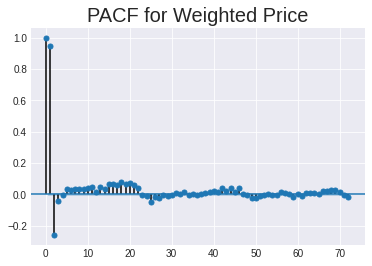

In [ ]:
plot_pacf(series, lags=800, alpha=0.05, method='ols')
plt.title("PACF for Weighted Price", size=20)
plt.show()

In [ ]:
# Data with lag >26 is statistically insignificant and the impact on model is minimal

In [ ]:
stats, p, lags, critical_values = kpss(series, 'ct', nlags='auto')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [ ]:
print(f'Test Statistics : {stats}')
print(f'p-value : {p}')
print(f'Critical Values : {critical_values}')

if p < 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

Test Statistics : 0.35654363396393235
p-value : 0.01
Critical Values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary


In [ ]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    print (dfoutput)
    
    if p > 0.05:
        print('Series is not Stationary')
    else:
        print('Series is Stationary')

In [ ]:
adf_test(series)

Results of Dickey-Fuller Test:
Test Statistic                -1.317092e+01
p-value                        1.250933e-24
#Lags Used                     5.500000e+01
Number of Observations Used    4.435500e+04
Critical Value (1%)           -3.430497e+00
Critical Value (5%)           -2.861605e+00
Critical Value (10%)          -2.566805e+00
dtype: float64
Series is Stationary


In [ ]:
# series = series.to_frame()
series.reset_index(drop=False, inplace=True)

window1 = 3
window2 = 24
window3 = 48
feature = 'PM25'

series_rolled_3d = series.rolling(window=window1, min_periods=0)
series_rolled_7d = series.rolling(window=window2, min_periods=0)
series_rolled_30d = series.rolling(window=window2, min_periods=0)

series_mean_3d = series_rolled_3d.mean().shift(1).reset_index()
series_mean_7d = series_rolled_7d.mean().shift(1).reset_index()
series_mean_30d = series_rolled_30d.mean().shift(1).reset_index()

series_std_3d = series_rolled_3d.std().shift(1).reset_index()
series_std_7d = series_rolled_7d.std().shift(1).reset_index()
series_std_30d = series_rolled_30d.std().shift(1).reset_index()

series[f"{feature}_mean_lag{window1}"] = series_mean_3d['PM25']
series[f"{feature}_mean_lag{window2}"] = series_mean_7d['PM25']
series[f"{feature}_mean_lag{window3}"] = series_mean_30d['PM25']

series[f"{feature}_std_lag{window1}"] = series_std_3d['PM25']
series[f"{feature}_std_lag{window2}"] = series_std_7d['PM25']
series[f"{feature}_std_lag{window3}"] = series_std_30d['PM25']

series.fillna(series.mean(), inplace=True)

series.set_index("Date (LT)", drop=False, inplace=True)
series.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



,Date (LT),PM25,PM25_mean_lag3,PM25_mean_lag24,PM25_mean_lag48,PM25_std_lag3,PM25_std_lag24,PM25_std_lag48
Date (LT),,,,,,,,
2016-02-05 14:00:00,2016-02-05 14:00:00,0.0,53.550101,53.558178,53.558178,5.861852,16.024800,16.024800
2016-02-05 15:00:00,2016-02-05 15:00:00,68.0,0.000000,0.000000,0.000000,5.861852,16.024800,16.024800
2016-02-05 16:00:00,2016-02-05 16:00:00,75.0,34.000000,34.000000,34.000000,48.083261,48.083261,48.083261
2016-02-05 17:00:00,2016-02-05 17:00:00,78.0,47.666667,47.666667,47.666667,41.428654,41.428654,41.428654
2016-02-05 18:00:00,2016-02-05 18:00:00,80.0,73.666667,55.250000,55.250000,5.131601,37.070878,37.070878


In [ ]:
df = series.copy()

In [ ]:
df["month"] = df['Date (LT)'].dt.month

In [ ]:
df["month"] = df['Date (LT)'].dt.month
df["hour_of_day"] = df['Date (LT)'].dt.hour
df["day"] = df['Date (LT)'].dt.day
df["day_of_week"] = df['Date (LT)'].dt.dayofweek
df.head()

,Date (LT),PM25,PM25_mean_lag3,PM25_mean_lag24,PM25_mean_lag48,PM25_std_lag3,PM25_std_lag24,PM25_std_lag48,month,hour_of_day,day,day_of_week
Date (LT),,,,,,,,,,,,
2016-02-05 14:00:00,2016-02-05 14:00:00,0.0,53.550101,53.558178,53.558178,5.861852,16.024800,16.024800,2,14,5,4
2016-02-05 15:00:00,2016-02-05 15:00:00,68.0,0.000000,0.000000,0.000000,5.861852,16.024800,16.024800,2,15,5,4
2016-02-05 16:00:00,2016-02-05 16:00:00,75.0,34.000000,34.000000,34.000000,48.083261,48.083261,48.083261,2,16,5,4
2016-02-05 17:00:00,2016-02-05 17:00:00,78.0,47.666667,47.666667,47.666667,41.428654,41.428654,41.428654,2,17,5,4
2016-02-05 18:00:00,2016-02-05 18:00:00,80.0,73.666667,55.250000,55.250000,5.131601,37.070878,37.070878,2,18,5,4


In [ ]:
df.to_csv(root_path + "tmp.csv")

<a id="subsection-eight"></a>
# AUTO ARIMA

In [ ]:
! pip install pmdarima
import pmdarima as pm

     |████████████████████████████████| 1.5MB 15.3MB/s 
     |████████████████████████████████| 2.1MB 53.6MB/s 
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


In [ ]:
features = ['PM25_mean_lag3', 'PM25_mean_lag24',
       'PM25_mean_lag48', 'PM25_std_lag3', 'PM25_std_lag24', 'PM25_std_lag48',
       'month', 'hour_of_day', 'day', 'day_of_week']

In [ ]:
df_train = df[df['Date (LT)'] < "2020"]
df_valid = df[df['Date (LT)'] >= "2020"]

In [ ]:
model = pm.auto_arima(df_train.PM25, exogenous=df_train[features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.PM25, exogenous=df_train[features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=251422.776, Time=121.78 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=276427.883, Time=42.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=253247.660, Time=72.33 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=259080.157, Time=91.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=276622.412, Time=50.63 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=251418.709, Time=116.37 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=252586.499, Time=108.89 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=251736.501, Time=98.69 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=251457.002, Time=120.74 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=251752.967, Time=114.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=251409.846, Time=105.92 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=251471.396, Time=101.70 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=251424.737, Time=123.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=251430.509

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
model_pmdarima = model

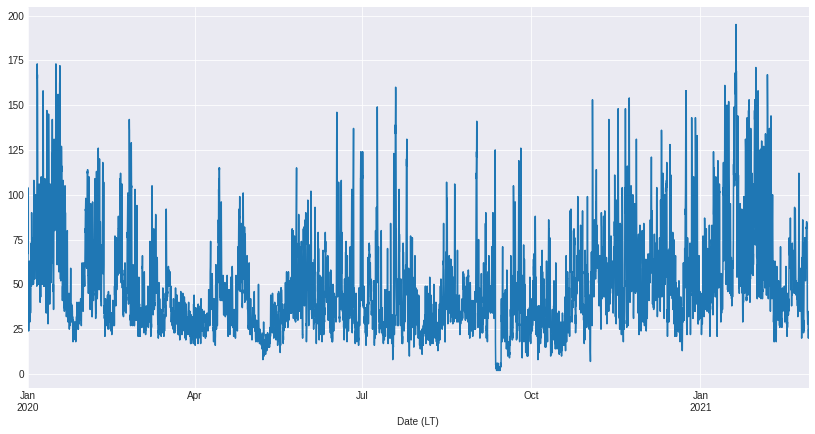

In [ ]:
df_valid["PM25"].plot(figsize=(14,7))

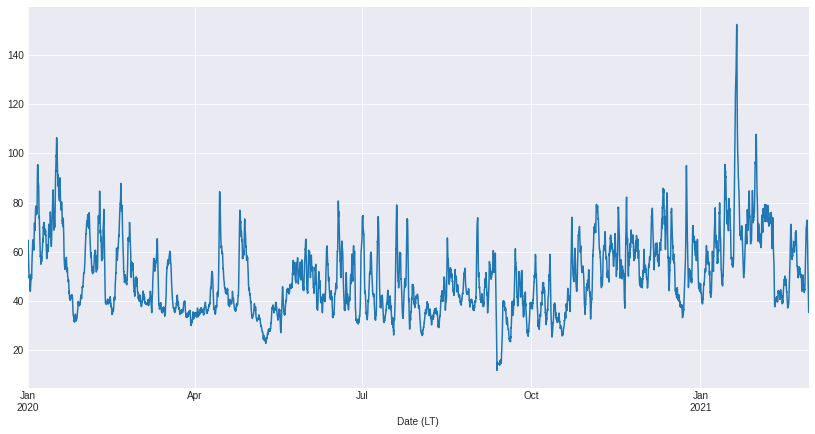

In [ ]:
df_valid["Forecast_ARIMAX"].plot(figsize=(14, 7))

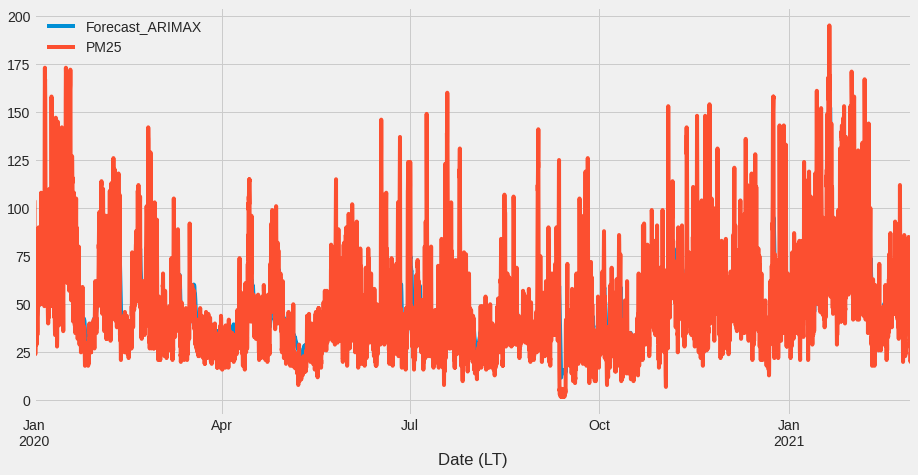

In [ ]:
df_valid[["Forecast_ARIMAX", "PM25"]].plot(figsize=(14, 7))

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

rmse_autoarima = sqrt(mean_squared_error(df_valid['PM25'],df_valid['Forecast_ARIMAX']))
# mape_autoarima = mean_absolute_percentage_error(df_valid['PM25'],df_valid['Forecast_ARIMAX'])
mae_autoarima = mean_absolute_error(df_valid['PM25'],df_valid['Forecast_ARIMAX'])
print("RMSE: {} / MAE: {}".format(rmse_autoarima, mae_autoarima))

RMSE: 19.93252439703009 / MAE: 14.594878707349784


<a id="subsection-eight"></a>
# CART

In [ ]:
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from datetime import datetime

In [ ]:
tree_reg = tree.DecisionTreeRegressor()

In [ ]:
X_train, y_train = df_train[features], df_train.PM25
X_test, y_test = df_valid[features], df_valid.PM25

In [ ]:
## Hyper Parameter Optimization Grid

params={
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "min_samples_split": [1, 3, 4, 5, 6, 7],
 "min_samples_leaf" : [1, 3, 4, 5, 6, 7]
}

In [ ]:
model_CART  = RandomizedSearchCV(    
                tree_reg,
                param_distributions=params,
                n_iter=10,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [ ]:
model_CART.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=None,
                                                   splitter='best'),
                   iid='d

In [ ]:
print(f"Model Best Score : {model_CART.best_score_}")
print(f"Model Best Parameters : {model_CART.best_estimator_.get_params()}")

Model Best Score : 0.790867482266108
Model Best Parameters : {'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 6, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



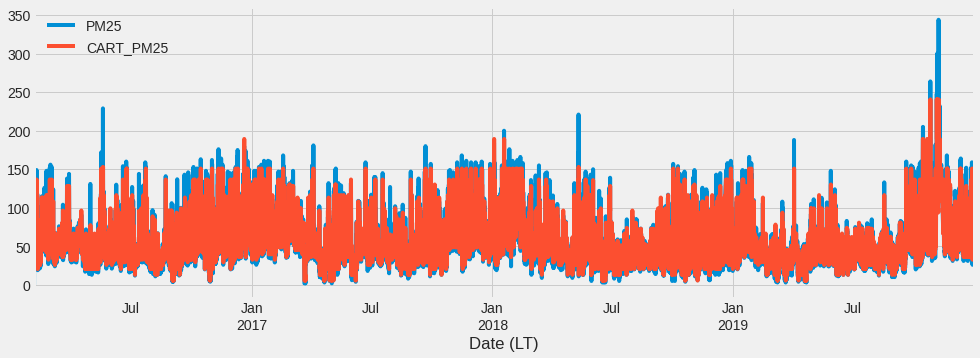

In [ ]:
df_train['CART_PM25'] = model_CART.predict(X_train)

df_train[['PM25','CART_PM25']].plot(figsize=(15, 5))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



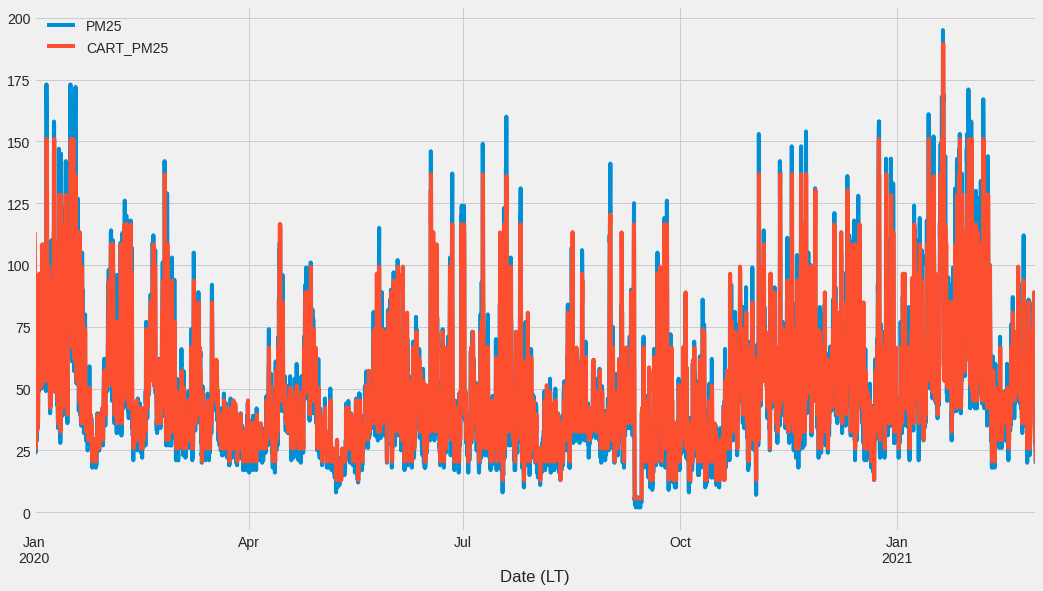

In [ ]:
df_valid['CART_PM25'] = model_CART.predict(X_test)

df_valid[['PM25','CART_PM25']].plot(figsize=(16, 9))

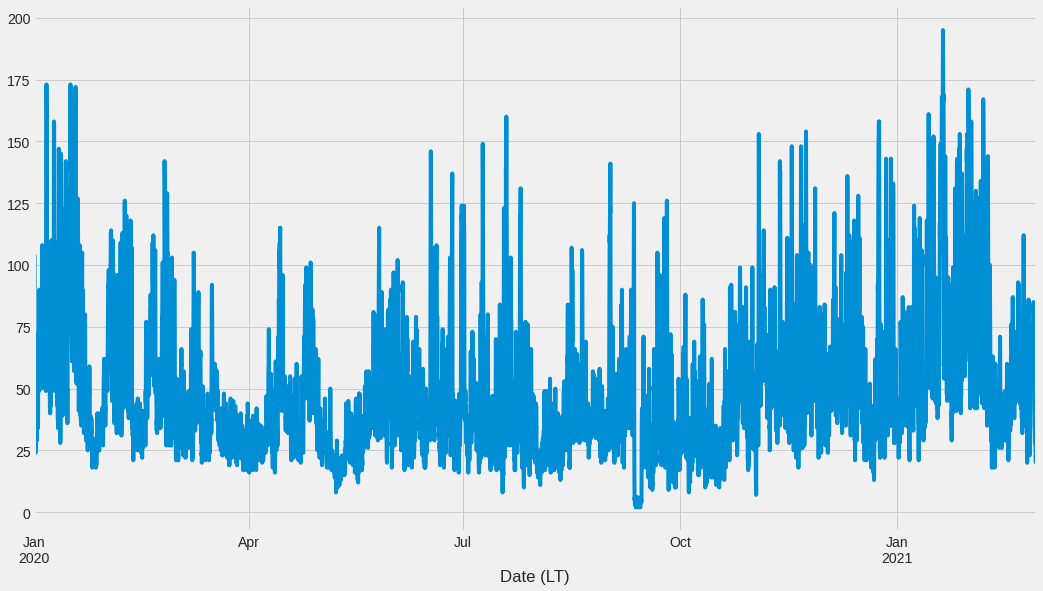

In [ ]:
df_valid['PM25'].plot(figsize=(16, 9))

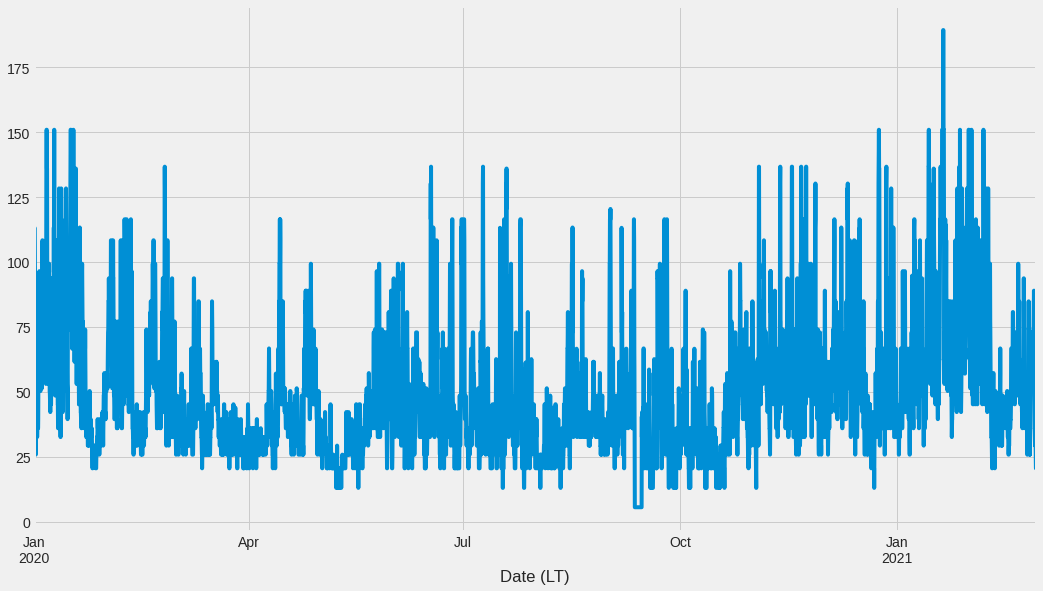

In [ ]:
df_valid['CART_PM25'].plot(figsize=(16, 9))

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

rmse_tree = sqrt(mean_squared_error(df_valid['PM25'],df_valid['CART_PM25']))
# mape_autoarima = mean_absolute_percentage_error(df_valid['PM25'],df_valid['Forecast_ARIMAX'])
mae_tree = mean_absolute_error(df_valid['PM25'],df_valid['CART_PM25'])
print("RMSE: {} / MAE: {}".format(rmse_tree, mae_tree))

RMSE: 11.599712177978763 / MAE: 8.079633303059962


<a id="subsection-eight"></a>
# XG Boost

In [ ]:
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from datetime import datetime

In [ ]:
reg = xgb.XGBRegressor()

In [ ]:
X_train, y_train = df_train[features], df_train.PM25
X_test, y_test = df_valid[features], df_valid.PM25

In [ ]:
## Hyper Parameter Optimization Grid

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
 
}

In [ ]:
model_xgboost  = RandomizedSearchCV(    
                reg,
                param_distributions=params,
                n_iter=10,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [ ]:
model_xgboost.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.9min finished


[03:48:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                                  0.6, 0.7, 0.8, 0.9, 1],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                  

In [ ]:
print(f"Model Best Score : {model_xgboost.best_score_}")
print(f"Model Best Parameters : {model_xgboost.best_estimator_.get_params()}")

Model Best Score : 0.8124864958186416
Model Best Parameters : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.9, 'gamma': 0.5, 'importance_type': 'gain', 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 14, 'missing': None, 'n_estimators': 1788, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.2, 'verbosity': 1}


In [ ]:
model_xgboost.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0.5,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=4, min_child_weight=14, missing=None, n_estimators=1788,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.2, verbosity=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



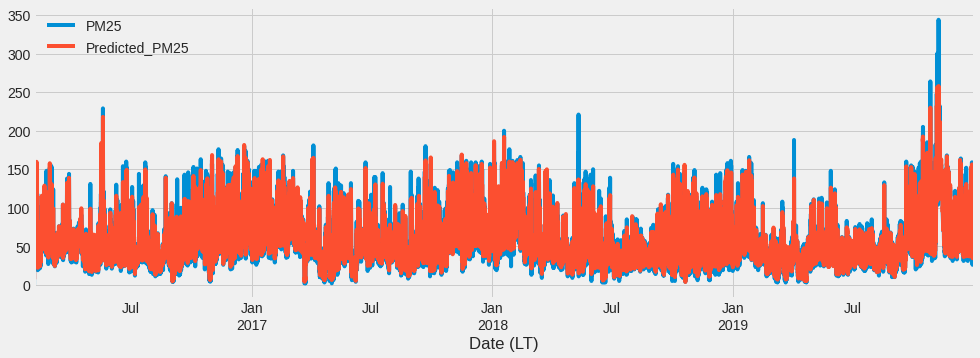

In [ ]:
df_train['Predicted_PM25'] = model_xgboost.predict(X_train)

df_train[['PM25','Predicted_PM25']].plot(figsize=(15, 5))

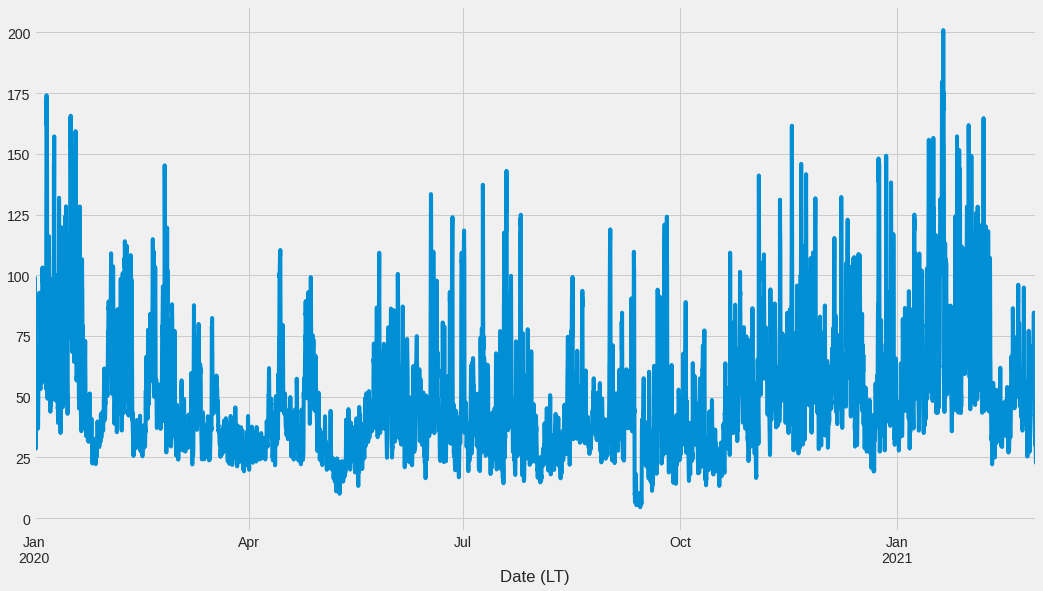

In [ ]:
df_valid['Predicted_PM25'].plot(figsize=(16,9))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



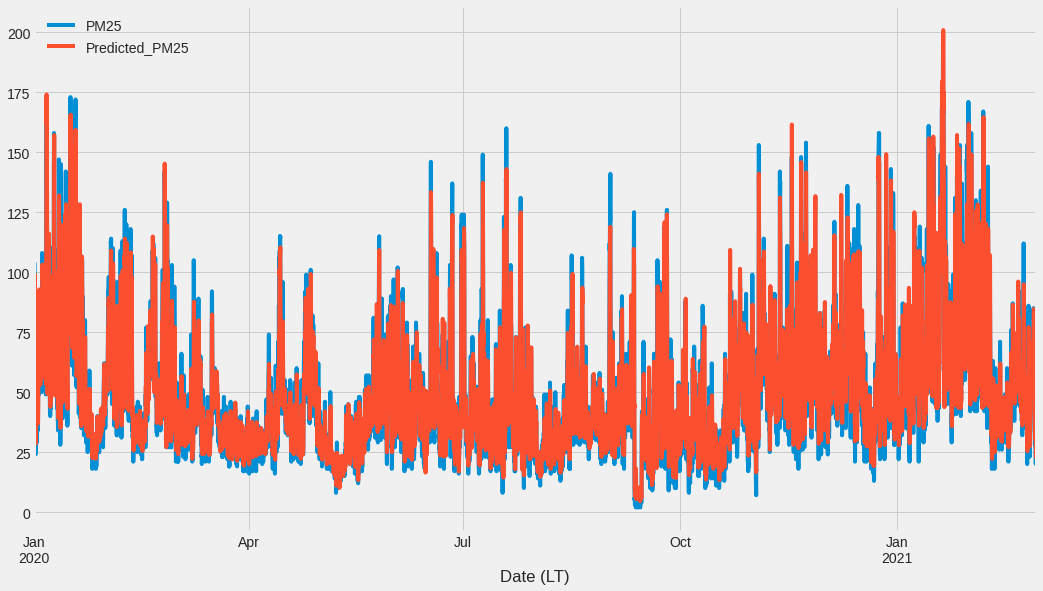

In [ ]:
df_valid['Predicted_PM25'] = model_xgboost.predict(X_test)
df_valid[['PM25', 'Predicted_PM25']].plot(figsize=(16,9))

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

rmse_xgboost = sqrt(mean_squared_error(df_valid['PM25'],df_valid['Predicted_PM25']))
# mape_autoarima = mean_absolute_percentage_error(df_valid['PM25'],df_valid['Forecast_ARIMAX'])
mae_xgboost = mean_absolute_error(df_valid['PM25'],df_valid['Predicted_PM25'])
print("RMSE: {} / MAE: {}".format(rmse_xgboost, mae_xgboost))

RMSE: 10.74505711720213 / MAE: 7.418837249962656


In [ ]:
# We need to know the number of continuous values
# So when we use chunker, we can refer to the starting point to know how many to skip if timeline is not continous after skipping
# Basic idea: Loop through the dataframe, if it is continuous increase the continous counter and pos counter
# If encounter uncontinous timeline (Encounter a nan value), find the lastpoint with a loop,
# Then change the start position continous length column values to the continous counter.
# Reset the continous counter and start counter
# Result: at the start of each continous timeline, there will be a number which indicate how many step you need to skip if
# you need to get to the next timeline
from IPython.core.debugger import set_trace

def time_continous_marker(df):
    df_copy = df.copy()
    pos = 0
    start_pos = 0
    continous = 0
    size = 24
    length = df_copy.shape[0]
    while pos < length:
        try:
#             set_trace()
            if df_copy.iloc[pos : pos + size, 1].isnull().sum() == 0:
                while df_copy.iloc[pos : pos + size, 1].isnull().sum() == 0:
                    pos += size
                    continous += size
            else:
                while np.isnan(df_copy.iloc[pos, 1]) == False:
                    continous += 1
                    pos += 1
                tmp.iloc[start_pos, 7] = continous
                continous = 0
                while np.isnan(df_copy.iloc[pos, 1]) == True:
                    pos += 1
                start_pos = pos
#             print(pos)
        except IndexError:
            df_copy.iloc[start_pos, 7] = continous
            continous = 0
            print("Current position is: {}".format(pos))
            pos = length
    return df_copy

In [ ]:
AQI = AQI.replace(0, np.nan).copy()
AQI['Continous length'] = 0
AQI = AQI.append(pd.Series(),ignore_index=True)
AQI = time_continous_marker(AQI)
AQI = AQI.dropna(subset=['AQI_h']).set_index("Date (LT)")
AQI.to_csv(_daisuquanmy_data_path + '/refined_data/refined.csv')

<ipython-input-6-17c9e192d088>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  AQI = AQI.append(pd.Series(),ignore_index=True)


NameError: name 'tmp' is not defined

In [ ]:
AQI = pd.read_csv(_daisuquanmy_data_path +'/refined_data/refined.csv')
AQI.loc[:, 'Date (LT)'] = pd.to_datetime(AQI['Date (LT)'], format="%Y-%m-%d %H:%M:%S")
AQI['site_id'] = 48
AQI.rename(columns={'Date (LT)': 'time'}, inplace=True)
AQI = AQI.set_index(['site_id', 'time'])
AQI_copy = AQI.copy()
AQI_copy

In [ ]:
AQI_copy.to_csv(_daisuquanmy_data_path + '/refined_data/refined.csv')

In [ ]:
test_df = AQI_copy.iloc[22090:22200].copy()
print(test_df.head(40))

                              PM25  AQI_h AQI_h_Polutant  \
site_id time                                               
48      2018-07-18 18:00:00   30.0   30.0           PM25   
        2018-07-18 19:00:00   36.0   36.0           PM25   
        2018-07-18 20:00:00   33.0   33.0           PM25   
        2018-07-18 21:00:00   45.0   45.0           PM25   
        2018-07-18 22:00:00   52.0   52.0           PM25   
        2018-07-18 23:00:00   44.0   44.0           PM25   
        2018-07-19 00:00:00   60.0   60.0           PM25   
        2018-07-19 01:00:00   52.0   52.0           PM25   
        2018-07-19 02:00:00   72.0   72.0           PM25   
        2018-07-19 03:00:00   64.0   64.0           PM25   
        2018-07-19 04:00:00   53.0   53.0           PM25   
        2018-07-19 05:00:00   95.0   95.0           PM25   
        2018-07-19 06:00:00   90.0   90.0           PM25   
        2018-07-19 07:00:00   57.0   57.0           PM25   
        2018-07-19 08:00:00   41.0   41.

In [ ]:
# Now chunker need to be able to output chunks of train data and target in correct order
# Basic ideas: loop through each chunk of data (size is size with ,
# if the timeline is continous, add data to chunk_data [pos: pos+size]
# add data to target [pos+size+target_hour]
# if the timeline is not, skip pos according to size
# Repeat below till timeline is continous
# if after skipping, the timeline is still not continous, skip pos according to continous length colunmns
from IPython.core.debugger import set_trace
def chunker(seq, size, target_hour, debug = True):
    """
    Input: 
        + Dataframe with PM25, AQI_h, AQI_h_I, Continous length and some other columns
            - If data doesn't have Continous length columns, add 1 to data
            - Take only PM25, date columns as train
            - Take only AQI_h, AQI_h_I as target
        + size: length of each chunk
        + target_hour: labels for the hour which will be predicted
    Ouput: 2 lists: chunk_data, target
        + chunk_data: original data chunked to a specific timestep, have shape [..., timeframe, features]
        + target: Label for each chunked train/test data, have shape [..., 1]
    """
    if not 'Continous length' in seq.columns:
        seq['Continous length'] = 0

    timerange = pd.Timedelta(hours=size + target_hour)
    chunk_data = []
    target = []
    multiclass_target = []
    pos = 0
    length = seq.shape[0]
    while pos < (length - size):
        try:
            if seq.iloc[pos + size + target_hour].name[1] - seq.iloc[pos].name[1] == timerange:
                while seq.iloc[pos + size + target_hour].name[1] - seq.iloc[pos].name[1] == timerange:
                    chunk_data.append(seq.iloc[pos:pos + size].loc['PM25','Hour','Day of Week'])
                    target.append(seq.iloc[pos + size + target_hour].loc['AQI_h'])
                    multiclass_target.append(seq.iloc[pos + size + target_hour].loc['AQI_h_I'])
                    pos += 1
                    if pos + size + target_hour >= length - size:
                        print("Returned")
                        return np.array(chunk_data), np.array(target), np.array(multiclass_target)
            else:
                tmp_pos = pos + size + target_hour
                while seq.iloc[tmp_pos + size + target_hour].name[1] - seq.iloc[tmp_pos].name[1] != timerange:
                    tmp_pos += int(seq.iloc[tmp_pos, 6])
                print("Jump from {} to {}".format(pos, tmp_pos))
                pos = tmp_pos
        except IndexError:
            print("Current position is: {}".format(pos))
            print("Current tmp position is: {}".format(tmp_pos))
            pos = length - size
    print("Returned")
    return np.array(chunk_data), np.array(target), np.array(multiclass_target)
chunk_data, target, multiclass_target = chunker(AQI_copy, 12, 0)

IndexingError: Too many indexers

In [ ]:
type(chunk_data[0, 0])

numpy.ndarray

In [ ]:
# Test chunker: Need to get date of target and date of data, then if 

In [ ]:
target

[array([157.0, 157.0, 'PM25', 'Unhealthy', 84.34990441728941, 4.0, 0.0],
       dtype=object),
 array([133.0, 133.0, 'PM25', 'Unhealthy for Sensitive', 66.6831787109375,
        3.0, 0.0], dtype=object),
 array([109.0, 109.0, 'PM25', 'Unhealthy for Sensitive', 54.43636474609375,
        3.0, 0.0], dtype=object),
 array([102.0, 102.0, 'PM25', 'Unhealthy for Sensitive', 51.11346435546875,
        3.0, 0.0], dtype=object),
 array([95.0, 95.0, 'PM25', 'Moderate', 47.3515380859375, 2.0, 0.0],
       dtype=object),
 array([83.0, 83.0, 'PM25', 'Moderate', 41.6702880859375, 2.0, 0.0],
       dtype=object),
 array([78.0, 78.0, 'PM25', 'Moderate', 38.8783935546875, 2.0, 0.0],
       dtype=object),
 array([78.0, 78.0, 'PM25', 'Moderate', 39.08306884765624, 2.0, 0.0],
       dtype=object),
 array([86.0, 86.0, 'PM25', 'Moderate', 42.9362548828125, 2.0, 0.0],
       dtype=object),
 array([85.0, 85.0, 'PM25', 'Moderate', 42.46347656250001, 2.0, 0.0],
       dtype=object),
 array([85.0, 85.0, 'PM25', 

In [ ]:
chunk_data

[array([[157.0, 157.0, 'PM25', 'Unhealthy', 89.89988876529476, 4.0, 374.0],
        [156.0, 156.0, 'PM25', 'Unhealthy', 88.39262369354849, 4.0, 0.0],
        [158.0, 158.0, 'PM25', 'Unhealthy', 84.85270608048593, 4.0, 0.0],
        [154.0, 154.0, 'PM25', 'Unhealthy', 84.91822551873828, 4.0, 0.0],
        [154.0, 154.0, 'PM25', 'Unhealthy', 86.06911091827958, 4.0, 0.0],
        [160.0, 160.0, 'PM25', 'Unhealthy', 94.14570783223152, 4.0, 0.0],
        [162.0, 162.0, 'PM25', 'Unhealthy', 96.14247113832728, 4.0, 0.0],
        [159.0, 159.0, 'PM25', 'Unhealthy', 93.11894930197607, 4.0, 0.0],
        [163.0, 163.0, 'PM25', 'Unhealthy', 87.7574932401444, 4.0, 0.0],
        [155.0, 155.0, 'PM25', 'Unhealthy', 86.37929606169355, 4.0, 0.0],
        [163.0, 163.0, 'PM25', 'Unhealthy', 98.51253065867742, 4.0, 0.0],
        [166.0, 166.0, 'PM25', 'Unhealthy', 102.04635607269579, 4.0, 0.0]],
       dtype=object),
 array([[156.0, 156.0, 'PM25', 'Unhealthy', 88.39262369354849, 4.0, 0.0],
        [158.

In [ ]:
import numpy
numpy.version.version

'1.19.2'

In [ ]:
chunk_data[0]

In [ ]:
set_trace()

In [ ]:
AQI_copy.shape

(38160, 7)

In [ ]:
# Checking
for data, tar in zip(chunk_data, target):
    if chunk_data

Data:                               PM25  AQI_h AQI_h_Polutant AQI_h_label  \
site_id time                                                           
48      2015-12-09 15:00:00  157.0  157.0           PM25   Unhealthy   
        2015-12-09 16:00:00  156.0  156.0           PM25   Unhealthy   
        2015-12-09 17:00:00  158.0  158.0           PM25   Unhealthy   
        2015-12-09 18:00:00  154.0  154.0           PM25   Unhealthy   
        2015-12-09 19:00:00  154.0  154.0           PM25   Unhealthy   
        2015-12-09 20:00:00  160.0  160.0           PM25   Unhealthy   
        2015-12-09 21:00:00  162.0  162.0           PM25   Unhealthy   
        2015-12-09 22:00:00  159.0  159.0           PM25   Unhealthy   
        2015-12-09 23:00:00  163.0  163.0           PM25   Unhealthy   
        2015-12-10 00:00:00  155.0  155.0           PM25   Unhealthy   
        2015-12-10 01:00:00  163.0  163.0           PM25   Unhealthy   
        2015-12-10 02:00:00  166.0  166.0           PM25  

In [ ]:
def chunker(seq, size):
    timerange = pd.Timedelta(hours=size + 1)
    chunks = []
    target = []
    pos = 0
    while pos < len(seq)-size:
#         print(seq.iloc[pos + size].name)
        if seq.iloc[pos + size + 1].name - seq.iloc[pos].name == timerange:
            chunks.append(seq.iloc[pos:pos + size])
            target.append(seq.iloc[pos + size + 1])
            pos += 1
        else:
            print("Jump from {} to {}".format(pos, pos + size))
            pos += size
    return chunks, target

train = []
tmp = test_df.copy()
for train_chunk, target_chunk in chunker(tmp, 12):
    train = train + [list(train_chunk.values)]
    target = target + [list(target_chunk.values)]
#     if hour != 0:
#         train = train[:-hour]
train = np.array(train)
print("Train shape: ",train.shape)
target = np.array(target)
print("Target shape: ", target.shape)

Jump from 16 to 28
Jump from 28 to 40


ValueError: too many values to unpack (expected 2)

In [ ]:
train

array([[[154.0, 154.0, 'PM25', 'Unhealthy', 4],
        [155.0, 155.0, 'PM25', 'Unhealthy', 4],
        [156.0, 156.0, 'PM25', 'Unhealthy', 4],
        ...,
        [155.0, 155.0, 'PM25', 'Unhealthy', 4],
        [153.0, 153.0, 'PM25', 'Unhealthy', 4],
        [153.0, 153.0, 'PM25', 'Unhealthy', 4]],

       [[155.0, 155.0, 'PM25', 'Unhealthy', 4],
        [156.0, 156.0, 'PM25', 'Unhealthy', 4],
        [156.0, 156.0, 'PM25', 'Unhealthy', 4],
        ...,
        [153.0, 153.0, 'PM25', 'Unhealthy', 4],
        [153.0, 153.0, 'PM25', 'Unhealthy', 4],
        [157.0, 157.0, 'PM25', 'Unhealthy', 4]],

       [[156.0, 156.0, 'PM25', 'Unhealthy', 4],
        [156.0, 156.0, 'PM25', 'Unhealthy', 4],
        [156.0, 156.0, 'PM25', 'Unhealthy', 4],
        ...,
        [153.0, 153.0, 'PM25', 'Unhealthy', 4],
        [157.0, 157.0, 'PM25', 'Unhealthy', 4],
        [161.0, 161.0, 'PM25', 'Unhealthy', 4]],

       ...,

       [[83.0, 83.0, 'PM25', 'Moderate', 2],
        [85.0, 85.0, 'PM25', 'Mod

In [ ]:
y = []
target = AQI[['AQI_h', 'AQI_I']].copy()
multiclass_y = []
site_ids = [48]
for site in site_ids:
    site_label = target.loc[site]
    site_label = site_label.shift(-12 - hour).dropna()
    site_label_y = list(site_label[['AQI_h']].values.ravel())
    site_label_multiclass_y = list(site_label[['AQI_h_I']].values.ravel())
    y = y + site_label_y
    multiclass_y = multiclass_y + site_label_multiclass_y
y = np.array(y)
multiclass_y = np.array(multiclass_y)
print("Label shape: ",y.shape)

In [ ]:
train

array([[[154.0, 154.0, 'PM25', 'Unhealthy', 4],
        [155.0, 155.0, 'PM25', 'Unhealthy', 4],
        [156.0, 156.0, 'PM25', 'Unhealthy', 4],
        ...,
        [155.0, 155.0, 'PM25', 'Unhealthy', 4],
        [153.0, 153.0, 'PM25', 'Unhealthy', 4],
        [153.0, 153.0, 'PM25', 'Unhealthy', 4]],

       [[155.0, 155.0, 'PM25', 'Unhealthy', 4],
        [156.0, 156.0, 'PM25', 'Unhealthy', 4],
        [156.0, 156.0, 'PM25', 'Unhealthy', 4],
        ...,
        [153.0, 153.0, 'PM25', 'Unhealthy', 4],
        [153.0, 153.0, 'PM25', 'Unhealthy', 4],
        [157.0, 157.0, 'PM25', 'Unhealthy', 4]],

       [[156.0, 156.0, 'PM25', 'Unhealthy', 4],
        [156.0, 156.0, 'PM25', 'Unhealthy', 4],
        [156.0, 156.0, 'PM25', 'Unhealthy', 4],
        ...,
        [153.0, 153.0, 'PM25', 'Unhealthy', 4],
        [157.0, 157.0, 'PM25', 'Unhealthy', 4],
        [161.0, 161.0, 'PM25', 'Unhealthy', 4]],

       ...,

       [[83.0, 83.0, 'PM25', 'Moderate', 2],
        [85.0, 85.0, 'PM25', 'Mod

In [ ]:
daisuquanmy_df_copy = daisuquanmy_df.copy()

In [ ]:
daisuquanmy_df_copy[daisuquanmy_df_copy['Year'] == 2019]

,Year,Month,Day,Hour,Raw Conc.,QC Name
Date (LT),,,,,,
2019-10-07 21:00:00,2019,10,7,21,77.0,Valid
2019-10-07 22:00:00,2019,10,7,22,80.0,Suspect
2019-10-07 23:00:00,2019,10,7,23,37.0,Invalid
2019-10-08 00:00:00,2019,10,8,0,29.0,Valid
2019-10-08 01:00:00,2019,10,8,1,49.0,Valid
...,...,...,...,...,...,...
2019-12-31 20:00:00,2019,12,31,20,88.0,Valid
2019-12-31 21:00:00,2019,12,31,21,91.0,Valid
2019-12-31 22:00:00,2019,12,31,22,99.0,Valid


In [ ]:
daisuquanmy_df_copy = daisuquanmy_df_copy[daisuquanmy_df_copy['Year'] == 2015]
# daisuquanmy_df_copy[daisuquanmy_df_copy['QC Name'] == "Valid"].iloc[0]
# Remove all data before 2015-12-09 14:00:00
daisuquanmy_df_copy = daisuquanmy_df_copy.loc[daisuquanmy_df_copy['Date (LT)'] >= pd.to_datetime("2015-12-09 14:00:00")]
daisuquanmy_df_copy = daisuquanmy_df_copy.replace(-999, np.nan)
daisuquanmy_df_copy.fillna(method='ffill', limit=2, inplace=True)
daisuquanmy_df_copy.fillna(method='bfill', limit=2, inplace=True)

In [ ]:
daisuquanmy_df_copy

,Year,Month,Day,Hour,Raw Conc.,QC Name
Date (LT),,,,,,
2015-12-09 14:00:00,2015,12,9,14,90.0,Valid
2015-12-09 15:00:00,2015,12,9,15,89.8,Valid
2015-12-09 16:00:00,2015,12,9,16,85.6,Valid
2015-12-09 17:00:00,2015,12,9,17,77.3,Valid
2015-12-09 18:00:00,2015,12,9,18,85.1,Valid
...,...,...,...,...,...,...
2021-02-28 20:00:00,2021,2,28,20,48.0,Valid
2021-02-28 21:00:00,2021,2,28,21,56.0,Valid
2021-02-28 22:00:00,2021,2,28,22,45.0,Valid


In [ ]:
# Downplaying the time from hour to date by mean


<ipython-input-16-ed1eacc1cdda>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes[counter] = fig.add_subplot(gs[counter, 0])
<ipython-input-16-ed1eacc1cdda>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes[counter] = fig.add_subplot(gs[counter, 0])
<ipython-input-16-ed1eacc1cdda>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a futur

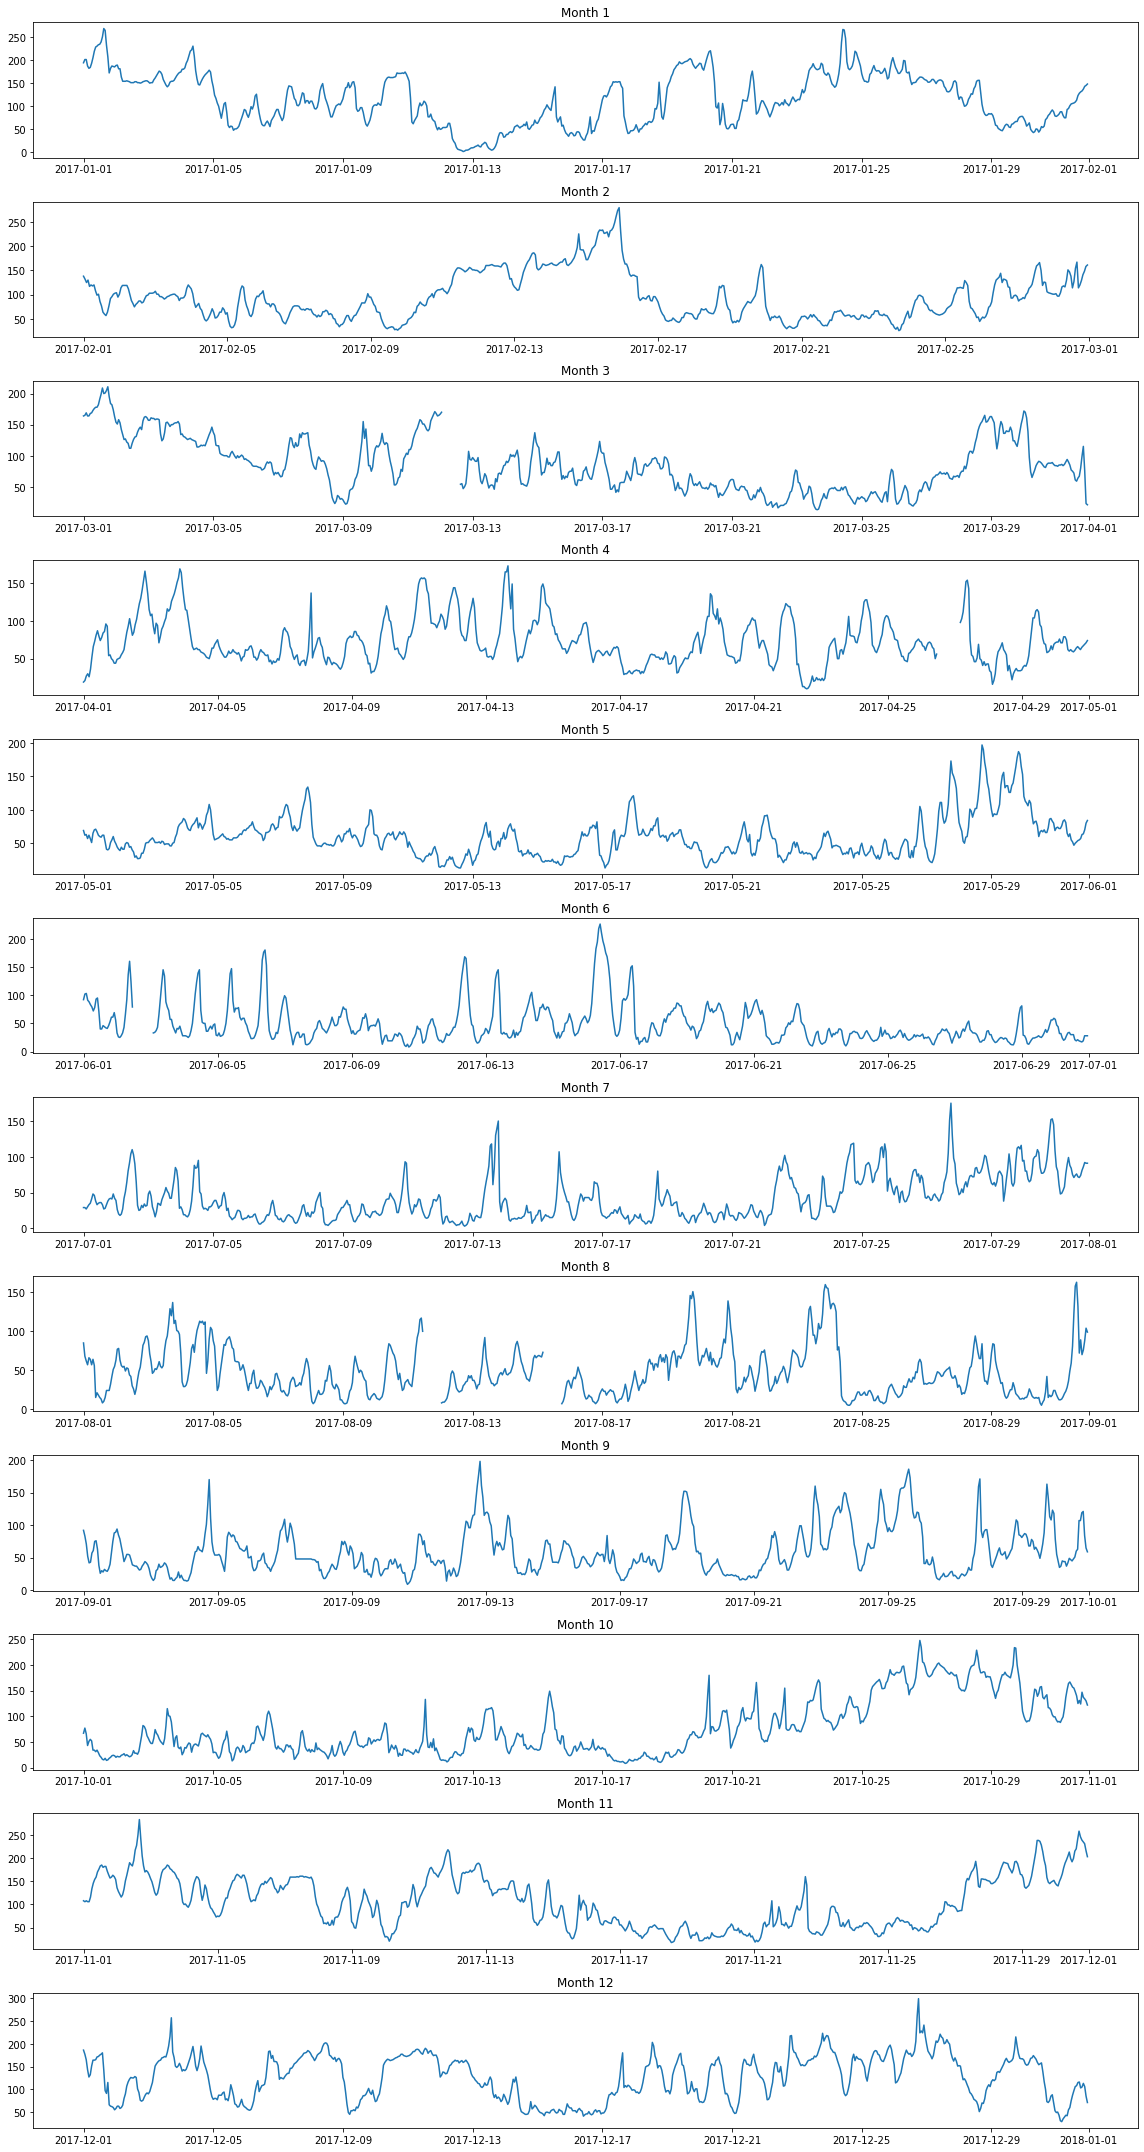

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,30))
gs = fig.add_gridspec(12,1)
axes = []
counter = 0
AQI_copy = AQI[AQI['Date (LT)'].dt.year == 2017].copy()
for month in AQI_copy['Date (LT)'].dt.month.unique():
    axes.append(fig.add_subplot(gs[counter,0]))
    axes[counter] = fig.add_subplot(gs[counter, 0])
    tmp = AQI_copy[AQI_copy['Date (LT)'].dt.month == month]
    axes[counter].plot(tmp['Date (LT)'], tmp['PM25'])
    axes[counter].set_title("Month {}".format(month))
    counter += 1
plt.tight_layout()
plt.show()

<ipython-input-2-e825b9025dc9>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes[counter] = fig.add_subplot(gs[counter, 0])
<ipython-input-2-e825b9025dc9>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes[counter] = fig.add_subplot(gs[counter, 0])
<ipython-input-2-e825b9025dc9>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future v

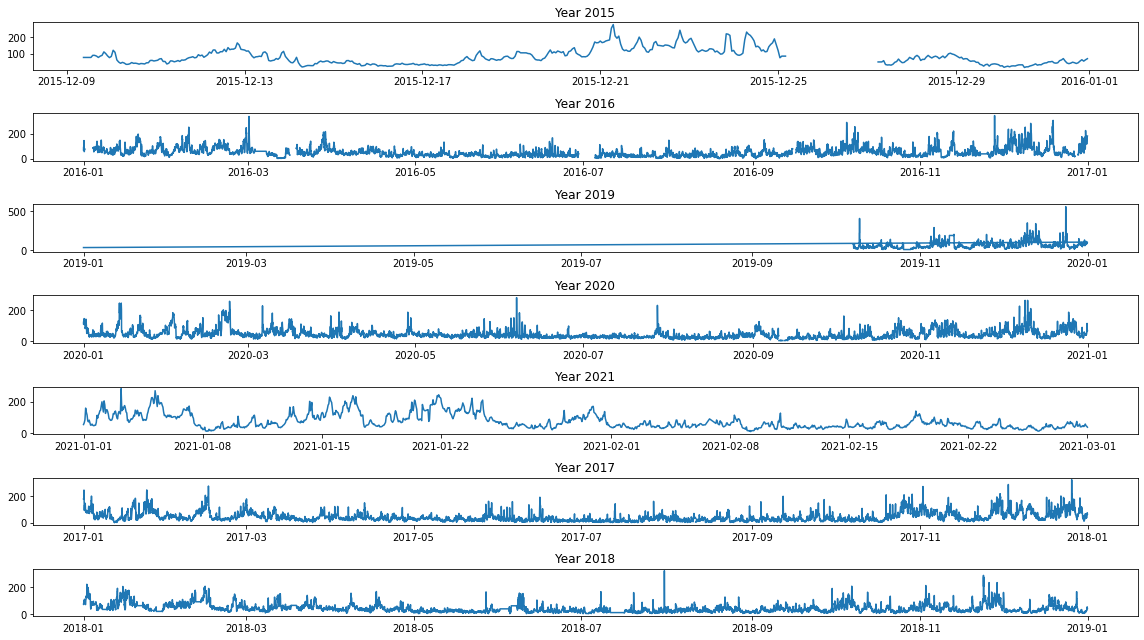

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,9))
gs = fig.add_gridspec(7,1)
axes = []
counter = 0
for year in daisuquanmy_df['Year'].unique():
    axes.append(fig.add_subplot(gs[counter,0]))
    axes[counter] = fig.add_subplot(gs[counter, 0])
    tmp = daisuquanmy_df[daisuquanmy_df['Year'] == year]
    axes[counter].plot(tmp.index, tmp['Raw Conc.'])
    axes[counter].set_title("Year {}".format(year))
    counter += 1
plt.tight_layout()
plt.show()

In [ ]:
daisuquanmy_df_copy

,Date (LT),Year,Month,Day,Hour,NowCast Conc.,Raw Conc.,QC Name
8221,2015-12-09 14:00:00,2015,12,9,14,87.0,90.0,Valid
8222,2015-12-09 15:00:00,2015,12,9,15,87.0,89.8,Valid
8223,2015-12-09 16:00:00,2015,12,9,16,86.5,85.6,Valid
8224,2015-12-09 17:00:00,2015,12,9,17,84.0,77.3,Valid
8225,2015-12-09 18:00:00,2015,12,9,18,84.2,85.1,Valid
...,...,...,...,...,...,...,...,...
8754,2015-12-31 19:00:00,2015,12,31,19,49.2,55.3,Valid
8755,2015-12-31 20:00:00,2015,12,31,20,55.4,63.6,Valid
8756,2015-12-31 21:00:00,2015,12,31,21,55.3,55.2,Valid
8757,2015-12-31 22:00:00,2015,12,31,22,57.8,63.2,Valid


In [ ]:
daisuquanmy_df_copy[daisuquanmy_df_copy['Raw Conc.'].isnull()]

,Date (LT),Year,Month,Day,Hour,NowCast Conc.,Raw Conc.,QC Name
8598,2015-12-25 07:00:00,2015,12,25,7,96.7,NaN,Missing
8599,2015-12-25 08:00:00,2015,12,25,8,96.7,NaN,Missing
8600,2015-12-25 09:00:00,2015,12,25,9,96.7,NaN,Missing
8601,2015-12-25 10:00:00,2015,12,25,10,96.7,NaN,Missing
8602,2015-12-25 11:00:00,2015,12,25,11,NaN,NaN,Missing
8603,2015-12-25 12:00:00,2015,12,25,12,NaN,NaN,Missing
8604,2015-12-25 13:00:00,2015,12,25,13,NaN,NaN,Missing
8605,2015-12-25 14:00:00,2015,12,25,14,NaN,NaN,Missing
8606,2015-12-25 15:00:00,2015,12,25,15,NaN,NaN,Missing
8607,2015-12-25 16:00:00,2015,12,25,16,NaN,NaN,Missing


In [ ]:
# Find first valid datapoint

In [ ]:
daisuquanmy_df['AQI'].describe()

count    37932.00000
mean        87.07756
std        168.49756
min       -999.00000
25%         74.00000
50%        103.00000
75%        152.00000
max        437.00000
Name: AQI, dtype: float64

In [ ]:
daisuquanmy_df['QC Name'].unique()

array(['Valid', 'Suspect', 'Invalid', 'Missing'], dtype=object)

In [ ]:
daisuquanmy_df[daisuquanmy_df['AQI Category'].isnull()]

,Site,Parameter,Date (LT),Year,Month,Day,Hour,NowCast Conc.,AQI,AQI Category,Raw Conc.,Conc. Unit,Duration,QC Name
0,Hanoi,PM2.5 - Principal,2019-10-07 21:00:00,2019,10,7,21,-999.0,-999,NaN,77.0,UG/M3,1 Hr,Valid
30,Hanoi,PM2.5 - Principal,2019-10-09 04:00:00,2019,10,9,4,-999.0,-999,NaN,16.0,UG/M3,1 Hr,Valid
44,Hanoi,PM2.5 - Principal,2019-10-09 20:00:00,2019,10,9,20,-999.0,-999,NaN,59.0,UG/M3,1 Hr,Valid
180,Hanoi,PM2.5 - Principal,2019-10-15 14:00:00,2019,10,15,14,-999.0,-999,NaN,26.0,UG/M3,1 Hr,Valid
435,Hanoi,PM2.5 - Principal,2019-10-28 15:00:00,2019,10,28,15,-999.0,-999,NaN,12.0,UG/M3,1 Hr,Valid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7259,Hanoi,PM2.5 - Principal,2018-11-17 00:00:00,2018,11,17,0,-999.0,-999,NaN,16.0,UG/M3,1 Hr,Invalid
7260,Hanoi,PM2.5 - Principal,2018-11-17 01:00:00,2018,11,17,1,-999.0,-999,NaN,16.0,UG/M3,1 Hr,Invalid
7261,Hanoi,PM2.5 - Principal,2018-11-17 02:00:00,2018,11,17,2,-999.0,-999,NaN,16.0,UG/M3,1 Hr,Invalid
7262,Hanoi,PM2.5 - Principal,2018-11-17 03:00:00,2018,11,17,3,-999.0,-999,NaN,15.0,UG/M3,1 Hr,Valid


In [ ]:
daisuquanmy_df[daisuquanmy_df['QC Name'] == "Missing"]

,Site,Parameter,Date (LT),Year,Month,Day,Hour,NowCast Conc.,AQI,AQI Category,Raw Conc.,Conc. Unit,Duration,QC Name
29,Hanoi,PM2.5 - Principal,2019-10-09 02:00 AM,2019,10,9,2,31.5,92,Moderate,-999.0,UG/M3,1 Hr,Missing
43,Hanoi,PM2.5 - Principal,2019-10-09 05:00 PM,2019,10,9,17,25.7,80,Moderate,-999.0,UG/M3,1 Hr,Missing
179,Hanoi,PM2.5 - Principal,2019-10-15 11:00 AM,2019,10,15,11,38.6,109,Unhealthy for Sensitive Groups,-999.0,UG/M3,1 Hr,Missing
183,Hanoi,PM2.5 - Principal,2019-10-15 05:00 PM,2019,10,15,17,32.2,93,Moderate,-999.0,UG/M3,1 Hr,Missing
431,Hanoi,PM2.5 - Principal,2019-10-26 01:00 AM,2019,10,26,1,80.3,164,Unhealthy,-999.0,UG/M3,1 Hr,Missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7029,Hanoi,PM2.5 - Principal,2018-11-07 09:00 AM,2018,11,7,9,44.7,124,Unhealthy for Sensitive Groups,-999.0,UG/M3,1 Hr,Missing
7051,Hanoi,PM2.5 - Principal,2018-11-08 08:00 AM,2018,11,8,8,45.4,125,Unhealthy for Sensitive Groups,-999.0,UG/M3,1 Hr,Missing
7413,Hanoi,PM2.5 - Principal,2018-11-23 10:00 AM,2018,11,23,10,30.7,90,Moderate,-999.0,UG/M3,1 Hr,Missing
7541,Hanoi,PM2.5 - Principal,2018-11-28 06:00 PM,2018,11,28,18,58.8,153,Unhealthy,-999.0,UG/M3,1 Hr,Missing


In [ ]:
daisuquanmy_df[daisuquanmy_df['Raw Conc.'] < 0]

,Site,Parameter,Date (LT),Year,Month,Day,Hour,NowCast Conc.,AQI,AQI Category,Raw Conc.,Conc. Unit,Duration,QC Name
29,Hanoi,PM2.5 - Principal,2019-10-09 02:00 AM,2019,10,9,2,31.5,92,Moderate,-999.0,UG/M3,1 Hr,Missing
43,Hanoi,PM2.5 - Principal,2019-10-09 05:00 PM,2019,10,9,17,25.7,80,Moderate,-999.0,UG/M3,1 Hr,Missing
179,Hanoi,PM2.5 - Principal,2019-10-15 11:00 AM,2019,10,15,11,38.6,109,Unhealthy for Sensitive Groups,-999.0,UG/M3,1 Hr,Missing
183,Hanoi,PM2.5 - Principal,2019-10-15 05:00 PM,2019,10,15,17,32.2,93,Moderate,-999.0,UG/M3,1 Hr,Missing
431,Hanoi,PM2.5 - Principal,2019-10-26 01:00 AM,2019,10,26,1,80.3,164,Unhealthy,-999.0,UG/M3,1 Hr,Missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7029,Hanoi,PM2.5 - Principal,2018-11-07 09:00 AM,2018,11,7,9,44.7,124,Unhealthy for Sensitive Groups,-999.0,UG/M3,1 Hr,Missing
7051,Hanoi,PM2.5 - Principal,2018-11-08 08:00 AM,2018,11,8,8,45.4,125,Unhealthy for Sensitive Groups,-999.0,UG/M3,1 Hr,Missing
7413,Hanoi,PM2.5 - Principal,2018-11-23 10:00 AM,2018,11,23,10,30.7,90,Moderate,-999.0,UG/M3,1 Hr,Missing
7541,Hanoi,PM2.5 - Principal,2018-11-28 06:00 PM,2018,11,28,18,58.8,153,Unhealthy,-999.0,UG/M3,1 Hr,Missing


In [ ]:
daisuquanmy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37932 entries, 8759 to 8338
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Site           37932 non-null  object 
 1   Parameter      37932 non-null  object 
 2   Date (LT)      37932 non-null  object 
 3   Year           37932 non-null  int64  
 4   Month          37932 non-null  int64  
 5   Day            37932 non-null  int64  
 6   Hour           37932 non-null  int64  
 7   NowCast Conc.  37932 non-null  float64
 8   AQI            37932 non-null  int64  
 9   AQI Category   37103 non-null  object 
 10  Raw Conc.      37932 non-null  float64
 11  Conc. Unit     37932 non-null  object 
 12  Duration       37932 non-null  object 
 13  QC Name        37932 non-null  object 
dtypes: float64(2), int64(5), object(7)
memory usage: 4.3+ MB


In [ ]:
daisuquanmy_df['Date (LT)'].unique()

array(['2016-01-01 12:00 AM', '2019-10-07 09:00 PM',
       '2019-10-07 10:00 PM', ..., '2018-12-31 10:00 PM',
       '2018-12-31 11:00 PM', '2019-01-01 12:00 AM'], dtype=object)

In [ ]:
daisuquanmy_df[daisuquanmy_df['QC Name'] == "Missing"]

,Site,Parameter,Date (LT),Year,Month,Day,Hour,NowCast Conc.,AQI,AQI Category,Raw Conc.,Conc. Unit,Duration,QC Name
29,Hanoi,PM2.5 - Principal,2019-10-09 02:00 AM,2019,10,9,2,31.5,92,Moderate,-999.0,UG/M3,1 Hr,Missing
43,Hanoi,PM2.5 - Principal,2019-10-09 05:00 PM,2019,10,9,17,25.7,80,Moderate,-999.0,UG/M3,1 Hr,Missing
179,Hanoi,PM2.5 - Principal,2019-10-15 11:00 AM,2019,10,15,11,38.6,109,Unhealthy for Sensitive Groups,-999.0,UG/M3,1 Hr,Missing
183,Hanoi,PM2.5 - Principal,2019-10-15 05:00 PM,2019,10,15,17,32.2,93,Moderate,-999.0,UG/M3,1 Hr,Missing
431,Hanoi,PM2.5 - Principal,2019-10-26 01:00 AM,2019,10,26,1,80.3,164,Unhealthy,-999.0,UG/M3,1 Hr,Missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7029,Hanoi,PM2.5 - Principal,2018-11-07 09:00 AM,2018,11,7,9,44.7,124,Unhealthy for Sensitive Groups,-999.0,UG/M3,1 Hr,Missing
7051,Hanoi,PM2.5 - Principal,2018-11-08 08:00 AM,2018,11,8,8,45.4,125,Unhealthy for Sensitive Groups,-999.0,UG/M3,1 Hr,Missing
7413,Hanoi,PM2.5 - Principal,2018-11-23 10:00 AM,2018,11,23,10,30.7,90,Moderate,-999.0,UG/M3,1 Hr,Missing
7541,Hanoi,PM2.5 - Principal,2018-11-28 06:00 PM,2018,11,28,18,58.8,153,Unhealthy,-999.0,UG/M3,1 Hr,Missing


In [ ]:
daisuquanmy_df[daisuquanmy_df.isnull().any(axis=1)]

,Site,Parameter,Date (LT),Year,Month,Day,Hour,NowCast Conc.,AQI,AQI Category,Raw Conc.,Conc. Unit,Duration,QC Name
0,Hanoi,PM2.5 - Principal,2019-10-07 09:00 PM,2019,10,7,21,-999.0,-999,NaN,77.0,UG/M3,1 Hr,Valid
30,Hanoi,PM2.5 - Principal,2019-10-09 04:00 AM,2019,10,9,4,-999.0,-999,NaN,16.0,UG/M3,1 Hr,Valid
44,Hanoi,PM2.5 - Principal,2019-10-09 08:00 PM,2019,10,9,20,-999.0,-999,NaN,59.0,UG/M3,1 Hr,Valid
180,Hanoi,PM2.5 - Principal,2019-10-15 02:00 PM,2019,10,15,14,-999.0,-999,NaN,26.0,UG/M3,1 Hr,Valid
435,Hanoi,PM2.5 - Principal,2019-10-28 03:00 PM,2019,10,28,15,-999.0,-999,NaN,12.0,UG/M3,1 Hr,Valid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7259,Hanoi,PM2.5 - Principal,2018-11-17 12:00 AM,2018,11,17,0,-999.0,-999,NaN,16.0,UG/M3,1 Hr,Invalid
7260,Hanoi,PM2.5 - Principal,2018-11-17 01:00 AM,2018,11,17,1,-999.0,-999,NaN,16.0,UG/M3,1 Hr,Invalid
7261,Hanoi,PM2.5 - Principal,2018-11-17 02:00 AM,2018,11,17,2,-999.0,-999,NaN,16.0,UG/M3,1 Hr,Invalid
7262,Hanoi,PM2.5 - Principal,2018-11-17 03:00 AM,2018,11,17,3,-999.0,-999,NaN,15.0,UG/M3,1 Hr,Valid


In [ ]:
thudohanoi_df_copy = thudohanoi_df.copy()
thudohanoi_df_copy = thudohanoi_df_copy.replace(0, np.nan)
thudohanoi_df_copy.head()

CO   NO2  O3  PM10  PM25  SO2
site_id time                                                 
30      2020-12-05 00:00:00  301.2  14.8 NaN  11.5   4.9  NaN
        2020-12-05 01:00:00  183.6  12.9 NaN  11.3   5.7  NaN
        2020-12-05 02:00:00  174.5  12.9 NaN  12.0   7.6  NaN
        2020-12-05 03:00:00  159.6  12.3 NaN  18.0  12.5  NaN
        2020-12-05 04:00:00  159.3  13.8 NaN  13.6   7.5  NaN

In [ ]:
thudohanoi_df_copy.isnull().sum()

CO        314
NO2       206
O3      72571
PM10      433
PM25      472
SO2     72515
dtype: int64

In [ ]:
thudohanoi_df_copy = thudohanoi_df_copy.replace(0, np.nan)
print(thudohanoi_df_copy.isnull().sum())
thudohanoi_df_copy = thudohanoi_df_copy.fillna(method='ffill', limit=2)
print(thudohanoi_df_copy.isnull().sum())
thudohanoi_df_copy = thudohanoi_df_copy.fillna(method='bfill', limit=2)
print(thudohanoi_df_copy.isnull().sum())

CO      314
NO2     206
PM25    472
dtype: int64
CO       60
NO2      25
PM25    136
dtype: int64
CO      20
NO2      3
PM25    99
dtype: int64


In [ ]:
from sklearn.impute import SimpleImputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
df_columns = thudohanoi_df_copy.columns
for column in df_columns:
    thudohanoi_df_copy.loc[:, column] = imp_median.fit_transform(thudohanoi_df_copy[[column]]).ravel()
